# 손 동작 인식
- 01. LSTM
- 02. KNN
- 03. RNN

In [2]:
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

2023-12-11 12:50:23.279114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 12:50:23.279227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 12:50:23.337376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 12:50:23.457752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 12:50:24.816323: W tensorflow/compiler/tf2

In [ ]:
# 파일 확인
# npy_data = np.load('./dataset/seq_go_1700819427.npy')
# npy_data = np.load('./dataset/seq_back_1700819496.npy')
npy_data = np.load('./dataset/seq_go_1700819427.npy')
# npy_data = np.load('./dataset/seq_go_1700819427.npy')
# npy_data = np.load('./dataset/seq_go_1700819427.npy')

print(npy_data.shape)

In [ ]:
npy_data = np.load('dataset/seq_back_1700819496.npy')

print(npy_data[0])

---

# 01. LSTM

## 01-1. LSTM - 데이터셋 구축

In [ ]:
max_num_hands = 1
actions = ['back']
# actions = ['go', 'back', 'stop', 'left_spin', 'right_spin', 'speed_up', 'speed_down', 'bad_gesture']

# 시퀀스 길이 지정
seq_length = 40
secs_for_action = 30

# 미디어파이프 패키지에서 손 인식을 위한 객체 생성
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands = max_num_hands,
    min_detection_confidence = 0.5,
    min_tracking_confidence = 0.5)

cap = cv2.VideoCapture(0)

created_time = str(time.strftime('%X', time.localtime(time.time())))
# exist_ok를 True로 설정하지 않았을 땐, 해당 디렉토리가 존재하는 경우 exception 에러 발생
os.makedirs('../data/dataset', exist_ok=True)

while cap.isOpened():

    for idx, action in enumerate(actions):

        data = []

        ret, img = cap.read()
        if not ret:
            print("카메라 연결 실패")
            # break
            continue

        img = cv2.flip(img, 1)
        cv2.putText(img, f'Waiting for collecting {action.upper()} action...', org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
        cv2.imshow('Dataset', img)
        cv2.waitKey(3000)

        start_time = time.time()

        while time.time() - start_time < secs_for_action:

            ret, img = cap.read()
            img = cv2.flip(img, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = hands.process(img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            if result.multi_hand_landmarks is not None:

                for res in result.multi_hand_landmarks:

                    joint = np.zeros((21, 4))

                    for j, lm in enumerate(res.landmark):
                        
                        joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

                    v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3]
                    v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3]
                    v = v2 - v1

                    v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                    angle = np.arccos(np.einsum('nt,nt->n',
                        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:]))

                    angle = np.degrees(angle)

                    angle_label = np.array([angle], dtype=np.float32)
                    angle_label = np.append(angle_label, 0)

                    d = np.concatenate([joint.flatten(), angle_label])

                    data.append(d)
                    # print(data)

                    mp_drawing.draw_landmarks(img,
                            res,
                            mp_hands.HAND_CONNECTIONS
                        #   mp_hands.get_default_hand_landmarks_style(),
                        #   mp_hands.get_default_hand_connections_style()
                    )

            cv2.imshow('Dataset', img)
            
            key = cv2.waitKey(5) & 0xFF
            
            if key == 27:  # ESC를 눌렀을 경우
                cv2.destroyAllWindows()
                cap.release()  # 비디오 캡처 객체 해제
                break

        data = np.array(data)
        print(action, data.shape)
        np.save(os.path.join('dataset', f'raw_{action}_{created_time}'), data)

        # seq 데이터 저장
        full_seq_data = []
        for seq in range(len(data) - seq_length):
            full_seq_data.append(data[seq:seq + seq_length])

        # raw 데이터 저장
        full_seq_data = np.array(full_seq_data)
        print(action, full_seq_data.shape)
        np.save(os.path.join('dataset', f'seq_{action}_{created_time}'), full_seq_data)
    
    break

## 01-2. LSTM - 학습

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
actions = ['go', 'back', 'stop', 'left_spin', 'right_spin', 'speed_up', 'speed_down', 'bad_gesture']
# actions = ['go', 'back', 'stop']

# 8가지 제스처
data = np.concatenate([
    np.load('./dataset/seq_go_1700819427.npy'),
    np.load('./dataset/seq_back_1700819496.npy'),
    np.load('./dataset/seq_stop_1700819547.npy'),
    np.load("./dataset/seq_left_spin_1700819603.npy"),
    np.load("./dataset/seq_right_spin_1700819656.npy"),
    np.load("./dataset/seq_speed_up_1700819724.npy"),
    np.load("./dataset/seq_speed_down_1700819854.npy"),
    np.load("./dataset/seq_bad_gesture_1700819908.npy")
], axis=0)

# 4가지 제스처
# data = np.concatenate([
#     np.load('./dataset/seq_go_1700819427.npy'),
#     np.load('./dataset/seq_back_1700819496.npy'),
#     np.load('./dataset/seq_stop_1700819547.npy')
# ], axis=0)

data.shape

(6936, 40, 100)

In [ ]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(6936, 40, 99)
(6936,)


In [ ]:
y_data = to_categorical(labels, num_classes=None)
y_data.shape

(6936, 8)

In [ ]:
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5548, 40, 99) (5548, 8)
(1388, 40, 99) (1388, 8)


In [ ]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                41984     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 8)                 264       
                                                                 
Total params: 44328 (173.16 KB)
Trainable params: 44328 (173.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=46,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/46
173/174 [============================>.] - ETA: 0s - loss: 54.7023 - acc: 0.2383
Epoch 1: val_acc improved from -inf to 0.28314, saving model to models/model.h5
174/174 [==============================] - 5s 18ms/step - loss: 54.6036 - acc: 0.2381 - val_loss: 17.5027 - val_acc: 0.2831 - lr: 0.0010
Epoch 2/46
 13/174 [=>............................] - ETA: 2s - loss: 17.8650 - acc: 0.2644

/home/ckdal/venv/pl_venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


173/174 [============================>.] - ETA: 0s - loss: 9.4359 - acc: 0.3309
Epoch 2: val_acc improved from 0.28314 to 0.39769, saving model to models/model.h5
174/174 [==============================] - 3s 16ms/step - loss: 9.4241 - acc: 0.3315 - val_loss: 6.7442 - val_acc: 0.3977 - lr: 0.0010
Epoch 3/46
171/174 [============================>.] - ETA: 0s - loss: 4.7868 - acc: 0.4311
Epoch 3: val_acc improved from 0.39769 to 0.49712, saving model to models/model.h5
174/174 [==============================] - 3s 14ms/step - loss: 4.7572 - acc: 0.4322 - val_loss: 3.2770 - val_acc: 0.4971 - lr: 0.0010
Epoch 4/46
174/174 [==============================] - ETA: 0s - loss: 3.8499 - acc: 0.5400
Epoch 4: val_acc improved from 0.49712 to 0.55476, saving model to models/model.h5
174/174 [==============================] - 3s 18ms/step - loss: 3.8499 - acc: 0.5400 - val_loss: 2.6295 - val_acc: 0.5548 - lr: 0.0010
Epoch 5/46
172/174 [============================>.] - ETA: 0s - loss: 3.8166 - acc: 

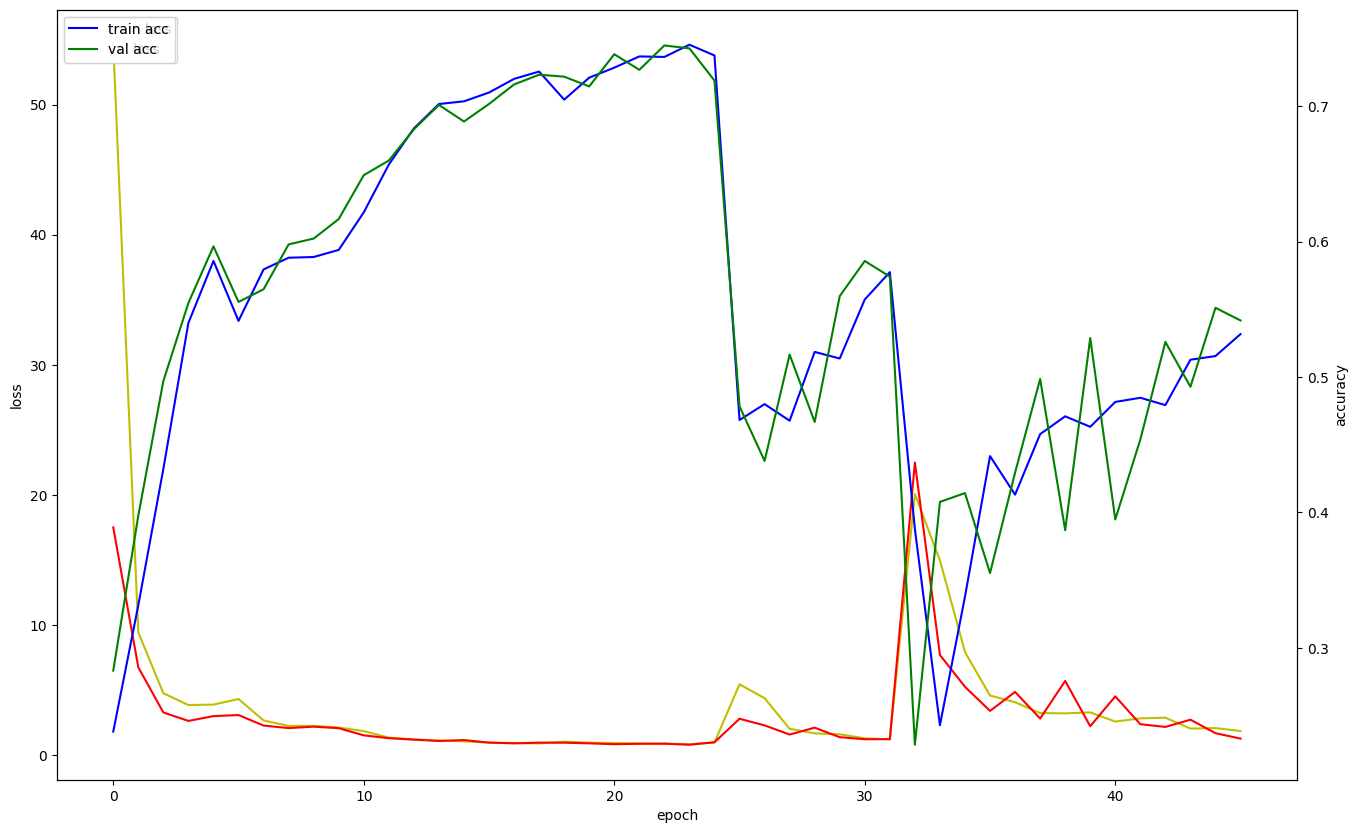

In [ ]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

44/44 [==============================] - 0s 4ms/step


array([[[1225,    1],
        [   9,  153]],

       [[1195,    9],
        [   0,  184]],

       [[1184,   49],
        [  41,  114]],

       [[1132,   66],
        [  52,  138]],

       [[1127,   71],
        [  97,   93]],

       [[1172,   39],
        [ 128,   49]],

       [[1112,  118],
        [  27,  131]],

       [[1215,    1],
        [   0,  172]]])

## 01-3. LSTM - 성능 검증

In [73]:
# 8가지 제스처 인식 Test
max_num_hands = 1
actions = ['go', 'back', 'stop', 'left_spin', 'right_spin', 'speed_up', 'speed_down', 'bad_gesture']
# actions = ['go', 'back', 'stop']

# 시퀀스 길이 지정
seq_length = 40

model = keras.models.load_model("/home/ckdal/dev_ws/project/Dl_Project/opensource/pp제스처git/models/model.h5")

# 미디어파이프 패키지에서 손 인식을 위한 객체 생성
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands = max_num_hands,
    min_detection_confidence = 0.5,
    min_tracking_confidence = 0.5)

cap = cv2.VideoCapture(2)

seq = []
action_seq = []

while cap.isOpened():

    ret, img = cap.read()
    if not ret:
        print("카메라 연결 실패")
        # break
        continue
    
    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # 손 인식 여부 확인
    if result.multi_hand_landmarks is not None:

        for res in result.multi_hand_landmarks:
        
            joint = np.zeros((21, 4))
        
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3]
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3]
            v = v2 - v1 # [20, 3]

            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle)

            d = np.concatenate([joint.flatten(), angle])

            seq.append(d)

            mp_drawing.draw_landmarks(img,
                                      res,
                                      mp_hands.HAND_CONNECTIONS
                                    #   mp_hands.get_default_hand_landmarks_style(),
                                    #   mp_hands.get_default_hand_connections_style()
            )

            if len(seq) < seq_length:
                continue

            input_data = np.expand_dims(np.array(seq[-seq_length:], dtype=np.float32), axis=0)

            y_pred = model.predict(input_data).squeeze()

            i_pred = int(np.argmax(y_pred))
            conf = y_pred[i_pred]

            if conf < 0.9:
                continue

            action = actions[i_pred]
            action_seq.append(action)

            if len(action_seq) < 8:
                continue

            this_action = '?'
            if action_seq[-1] == action_seq[-2] == action_seq[-3]:
                this_action = action

            cv2.putText(img, f'{this_action.upper()}', org=(int(res.landmark[0].x * img.shape[1]), int(res.landmark[0].y * img.shape[0] + 20)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

    cv2.imshow('Test', img)

    key = cv2.waitKey(5) & 0xFF

    if key == 27:
        cv2.destroyAllWindows()
        cap.release()
        break

I0000 00:00:1701393077.918570   18586 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1701393077.920655   36747 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)


1/1 [==============================] - 0s 29ms/step


---

# 02. KNN

## 02-1. KNN - 데이터셋 구축

In [55]:
max_num_hands = 1
count_click = 0

# 제스처 클래스 정의
gestures = {
    0:'go', 1:'back', 2:'stop', 3:'left_spin', 4:'right_spin', 5:'speed_up',
    6:'speed_down', 7:'bad_gesture'}
action_label = 0
action = str(gestures[action_label])

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands=max_num_hands,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

file = np.genfromtxt('../data/gesture_train_tovstack.csv', delimiter=',')
print("csv파일 로드됨", file.shape)

cap = cv2.VideoCapture(0)

# 클릭 이벤트
# 화면을 클릭했을 때 각도 값을 csv파일에 추가
def click(event, x, y, flags, param):
    global data, file, count_click
    if event == cv2.EVENT_LBUTTONDOWN:
        count_click += 1
        file = np.vstack((file, data))  # numpy의 vstack 사용
        print(file.shape)

cv2.namedWindow('Dataset')
cv2.setMouseCallback('Dataset', click)

while cap.isOpened():

    ret, img = cap.read()

    if not ret:
        print("카메라 연결 실패")
        # break
        continue

    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    cv2.putText(img, action, org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=3)
    cv2.putText(img, str(count_click), org=(10, 80), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
    
    # 손 인식 여부 확인
    if result.multi_hand_landmarks is not None:

        for res in result.multi_hand_landmarks:

            joint = np.zeros((21, 3))

            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z]

            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:]
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:]
            v = v2 - v1 # [20,3]

            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle)

            data = np.array([angle], dtype=np.float32)
            data = np.append(data, action_label)
            
            # 각도값 출력 확인
            # print(data)

            mp_drawing.draw_landmarks(img,
                                      res,
                                      mp_hands.HAND_CONNECTIONS
                                    #   mp_hands.get_default_hand_landmarks_style(),
                                    #   mp_hands.get_default_hand_connections_style()
            )

    cv2.imshow('Dataset', img)

    key = cv2.waitKey(5) & 0xFF

    if key == ord('a'):
        created_time = str(time.strftime('%X', time.localtime(time.time())))
        os.makedirs('../data/dataset', exist_ok=True)
        np.savetxt(os.path.join('../data/dataset', f'{action}_{created_time}.csv'), file[1:], delimiter=',')
        
        if action_label == 7:
            action_label = 0
        else:
            action_label += 1
        action = str(gestures[action_label])
        count_click = 0

        file = np.genfromtxt('../data/gesture_train_tovstack.csv', delimiter=',')
        print("csv파일 로드됨", file.shape)

    if key == 27:
        cv2.destroyAllWindows()
        cap.release()
        break


created_time = str(time.strftime('%X', time.localtime(time.time())))
# exist_ok를 True로 설정하지 않았을 땐, 해당 디렉토리가 존재하는 경우 exception 에러 발생
os.makedirs('../data/dataset', exist_ok=True)
# 한 동작만 저장
action = str(gestures[action_label])
np.savetxt(os.path.join('../data/dataset', f'{action}_{created_time}.csv'), file[1:], delimiter=',')

csv파일 로드됨 (16,)


I0000 00:00:1702281672.960599    7169 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702281672.961473   73687 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)


(2, 16)
(3, 16)
(4, 16)
(5, 16)
(6, 16)
(7, 16)
(8, 16)
(9, 16)
(10, 16)
(11, 16)
(12, 16)
(13, 16)
(14, 16)
(15, 16)
(16, 16)
(17, 16)
(18, 16)
(19, 16)
(20, 16)
(21, 16)
(22, 16)
(23, 16)
(24, 16)
(25, 16)
(26, 16)
(27, 16)
(28, 16)
(29, 16)
(30, 16)
(31, 16)
(32, 16)
(33, 16)
(34, 16)
(35, 16)
(36, 16)
(37, 16)
(38, 16)
(39, 16)
(40, 16)
(41, 16)
(42, 16)
(43, 16)
(44, 16)
(45, 16)
(46, 16)
(47, 16)
(48, 16)
(49, 16)
(50, 16)
(51, 16)
(52, 16)
(53, 16)
(54, 16)
(55, 16)
(56, 16)
(57, 16)
(58, 16)
(59, 16)
(60, 16)
(61, 16)
(62, 16)
(63, 16)
(64, 16)
(65, 16)
(66, 16)
(67, 16)
(68, 16)
(69, 16)
(70, 16)
(71, 16)
(72, 16)
(73, 16)
(74, 16)
(75, 16)
(76, 16)
(77, 16)
(78, 16)
(79, 16)
(80, 16)
(81, 16)
(82, 16)
(83, 16)
(84, 16)
(85, 16)
(86, 16)
(87, 16)
(88, 16)
(89, 16)
(90, 16)
(91, 16)
(92, 16)
(93, 16)
(94, 16)
(95, 16)
(96, 16)
(97, 16)
(98, 16)
(99, 16)
(100, 16)
(101, 16)
csv파일 로드됨 (16,)
(2, 16)
(3, 16)
(4, 16)
(5, 16)
(6, 16)
(7, 16)
(8, 16)
(9, 16)
(10, 16)
(11, 16)
(12, 16)

## 02-2. KNN - 성능 검증

In [56]:
# 제스처당 10개 dataset
df_file_10_go = pd.read_csv('../data/dataset_10_231211/go_04:54:34 PM.csv', header=None)
df_file_10_back = pd.read_csv('../data/dataset_10_231211/back_04:55:04 PM.csv', header=None)
df_file_10_stop = pd.read_csv('../data/dataset_10_231211/stop_04:55:31 PM.csv', header=None)
df_file_10_left = pd.read_csv('../data/dataset_10_231211/left_spin_04:55:49 PM.csv', header=None)
df_file_10_right = pd.read_csv('../data/dataset_10_231211/right_spin_04:56:08 PM.csv', header=None)
df_file_10_up = pd.read_csv('../data/dataset_10_231211/speed_up_04:57:54 PM.csv', header=None)
df_file_10_down = pd.read_csv('../data/dataset_10_231211/speed_down_04:58:18 PM.csv', header=None)
df_file_10_bad = pd.read_csv('../data/dataset_10_231211/bad_gesture_05:00:03 PM.csv', header=None)

df_file_10 = pd.concat([df_file_10_go, df_file_10_back, df_file_10_stop, df_file_10_left, df_file_10_right, df_file_10_up, df_file_10_down, df_file_10_bad], ignore_index=True)
df_file_10.to_csv("../data/dataset_10_231211/total_10.csv", index=None, header=None)

In [74]:
# 제스처당 100개 dataset
df_file_100_go = pd.read_csv('../data/dataset_100_231211_2/go_05:04:05 PM.csv', header=None)
df_file_100_back = pd.read_csv('../data/dataset_100_231211_2/back_05:06:55 PM.csv', header=None)
df_file_100_stop = pd.read_csv('../data/dataset_100_231211_2/stop_05:09:41 PM.csv', header=None)
df_file_100_left = pd.read_csv('../data/dataset_100_231211_2/left_spin_05:12:50 PM.csv', header=None)
df_file_100_right = pd.read_csv('../data/dataset_100_231211_2/right_spin_05:15:07 PM.csv', header=None)
df_file_100_up = pd.read_csv('../data/dataset_100_231211_2/speed_up_05:18:02 PM.csv', header=None)
df_file_100_down = pd.read_csv('../data/dataset_100_231211_2/speed_down_05:20:26 PM.csv', header=None)
df_file_100_bad = pd.read_csv('../data/dataset_100_231211_2/bad_gesture_05:23:23 PM.csv', header=None)

df_file_100 = pd.concat([df_file_100_go, df_file_100_back, df_file_100_stop, df_file_100_left, df_file_100_right, df_file_100_up, df_file_100_down, df_file_100_bad], ignore_index=True)
df_file_100.to_csv("../data/dataset_100_231211_2/total_100.csv", index=None, header=None)

In [85]:
file = np.genfromtxt('../data/dataset_10_231211/total_10.csv', delimiter=',')
# file = np.genfromtxt('../data/dataset_100_231211_2/total_100.csv', delimiter=',')
# file = np.genfromtxt('../data/dataset_2_1/bad_gesture_03:15:29 AM.csv', delimiter=',')

In [86]:
file.shape

(80, 16)

In [80]:
# x데이터와 y데이터 나누기
# train셋, test셋 split
# file = np.genfromtxt('../data/dataset_2_1/bad_gesture_03:15:29 AM.csv', delimiter=',')
angle = file[:,:-1].astype(np.float32)
label = file[:, -1].astype(np.float32)

X_train, X_test, y_train, y_test = model_selection.train_test_split(angle,
                                                                    label,
                                                                    test_size = 0.2,
                                                                    random_state = 2023)

In [81]:
len(X_test)

160

In [82]:
# KNN 모델 생성 후 학습
knn = cv2.ml.KNearest_create()
knn.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

True

In [83]:
# 정확도 계산
ret, result, neighbours, dist = knn.findNearest(np.array(X_test, dtype=np.float32), k=3)
accuracy = accuracy_score(y_test, result.flatten())
print(f'Accuracy: {accuracy}')

Accuracy: 0.975


In [84]:
# 인식 결과를 단순히 출력하도록
max_num_hands = 1

gestures = {
    0:'go', 1:'back', 2:'stop', 3:'left_spin', 4:'right_spin', 5:'speed_up',
    6:'speed_down', 7:'bad_gesture'}

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands=max_num_hands,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

file = np.genfromtxt('../data/dataset_100_231211_2/total_100.csv', delimiter=',')
angle = file[:,:-1].astype(np.float32)
label = file[:, -1].astype(np.float32)
knn = cv2.ml.KNearest_create()
knn.train(angle, cv2.ml.ROW_SAMPLE, label)

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, img = cap.read()

    if not ret:
        print("카메라 연결 실패")
        break
        # continue

    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result = hands.process(img)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if result.multi_hand_landmarks is not None:

        for res in result.multi_hand_landmarks:

            joint = np.zeros((21, 3))

            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z]

            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:]
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:]
            v = v2 - v1 # [20,3]

            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle)

            data = np.array([angle], dtype=np.float32)
            ret, results, neighbours, dist = knn.findNearest(data, 5)
            idx = int(results[0][0])

            if idx in gestures.keys():
                cv2.putText(img, text=gestures[idx].upper(), org=(int(res.landmark[0].x * img.shape[1]), int(res.landmark[0].y * img.shape[0] + 20)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

            mp_drawing.draw_landmarks(img,
                                      res,
                                      mp_hands.HAND_CONNECTIONS
                                    #   mp_hands.get_default_hand_landmarks_style(),
                                    #   mp_hands.get_default_hand_connections_style()
            )
    
    cv2.imshow('Test', img)

    key = cv2.waitKey(5) & 0xFF

    if key == 27:
        cv2.destroyAllWindows()
        cap.release()
        break

I0000 00:00:1702284721.226737    7169 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702284721.227843   75142 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)


# 03. RNN

## 03-1. RNN - 모델 생성 후 학습

In [105]:
# df_file = pd.read_csv('../data/dataset_10_231211/total_10.csv', delimiter=',', header=None)
df_file = pd.read_csv('../data/dataset_100_231211_2/total_100.csv', delimiter=',', header=None)

In [106]:
df_file.shape

(800, 16)

In [107]:
df_file

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,20.817553,6.911163,13.913456,11.891656,7.431317,5.680053,6.239611,4.427707,3.422860,9.662763,3.757614,4.510948,4.989828,5.536578,4.706629,0.0
1,17.436653,3.327865,20.474810,6.176126,3.330752,3.422201,2.895099,3.855422,2.389583,5.062871,3.134106,4.606619,8.898752,4.048503,6.283424,0.0
2,17.762844,7.114627,8.630678,11.170781,9.344625,5.904938,4.165658,6.866282,4.478986,5.621472,5.232038,5.797524,2.415509,7.242287,7.996302,0.0
3,19.550770,12.552555,20.597082,16.350975,11.464218,6.685272,8.198183,6.388839,4.680421,9.917696,5.143094,6.091669,1.582255,6.358165,6.398254,0.0
4,19.223051,3.957166,13.519729,7.740565,4.435032,4.299756,3.553062,4.972548,3.501531,1.849782,5.823893,5.117098,8.688388,6.932795,6.490625,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,32.363659,15.577159,32.668846,38.600334,94.585861,56.851692,45.577324,6.582920,16.107603,73.659637,71.023376,48.703438,83.975502,64.367081,40.280941,7.0
796,31.872707,20.150658,45.110435,28.549080,117.074310,38.961689,31.785032,7.770251,10.991480,71.379311,72.125885,54.303837,95.119141,58.032421,37.676659,7.0
797,23.975588,8.008963,14.328184,30.514959,91.281586,28.018032,16.497669,17.120991,11.196115,25.950314,128.337112,17.018614,51.290264,117.223816,20.038288,7.0
798,24.604853,10.077657,18.128210,25.286041,105.439560,24.751562,12.923851,16.054342,7.480577,19.583553,143.034241,13.651463,42.423565,130.454437,14.911717,7.0


In [108]:
# x데이터와 y데이터 나누기
# train셋, test셋 split
# df_file = pd.read_csv('/home/ckdal/dev_ws/project/Dl_Project/data/dataset_knn_1211/bad_gesture_01:03:08 PM.csv', header=None)
df_angle = df_file.iloc[:, 0:15]
df_label = df_file.iloc[:, -1]

# 훈련 데이터는 전체 데이터를 대표할 수 있도록 라벨이 골고루 포함되어야 함
# stratify: 원래 데이터의 분포와 유사하게 데이터를 추출해주는 파라미터
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_angle,
                                                                    df_label,
                                                                    test_size = 0.2,
                                                                    random_state = 2023,
                                                                    stratify=df_label)

In [109]:
# y_train
# y_test

In [110]:
# one-hot encoding
encoder = OneHotEncoder(sparse_output = False)

y_train_np = y_train.to_numpy()
# 1D 배열을 열이 1인 2D 배열로 변환
y_train_2d = y_train_np.reshape(-1, 1)
y_train_encoded = encoder.fit_transform(y_train_2d)

y_test_np = y_test.to_numpy()
y_test_2d = y_test_np.reshape(-1, 1)
y_test_encoded = encoder.fit_transform(y_test_2d)

# y_train_encoded
y_test_encoded

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [111]:
y_train_encoded.shape
# y_test_encoded.shape

(640, 8)

In [112]:
# MLP 모델 생성
# 이진 분류
# model = models.Sequential()

# model.add(layers.Dense(input_dim=15, units=64, activation=None, kernel_initializer=initializers.he_uniform()))

# model.add(layers.Activation('elu'))

# model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
# model.add(layers.Activation('elu')) 

# model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
# model.add(layers.Activation('elu'))

# model.add(layers.Dropout(rate=0.5))

# # 출력 레이어
# model.add(layers.Dense(units=1, activation='sigmoid'))

# model.compile(optimizer=optimizers.Adam(),
#               loss=losses.binary_crossentropy,
#               metrics=[metrics.binary_accuracy])

In [113]:
# 모델 생성
# 다중 클래스 분류
model = models.Sequential()

model.add(layers.Dense(input_dim=15, units=64, activation=None, kernel_initializer=initializers.he_uniform()))

model.add(layers.Activation('elu'))

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dropout(rate=0.5))

# 출력 레이어
model.add(layers.Dense(units=8, activation='softmax'))

model.compile(optimizer=optimizers.Adam(),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy]) 

In [114]:
# model = Sequential()

# model.add(layers.LSTM(64, return_sequences=True,
#                 input_shape=(70, 84))) 

# model.add(layers.LSTM(32, return_sequences=True))

# model.add(layers.LSTM(32))

# model.add(layers.Dense(8, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#                 optimizer='adam',
#                 metrics=['accuracy'])

In [115]:
history = model.fit(X_train, y_train_encoded, batch_size = 200, epochs = 500, validation_split = 0.3)

Epoch 1/500


3/3 [==============================] - 1s 113ms/step - loss: 178.1456 - categorical_accuracy: 0.1250 - val_loss: 100.2381 - val_categorical_accuracy: 0.1979
Epoch 2/500
3/3 [==============================] - 0s 20ms/step - loss: 154.4971 - categorical_accuracy: 0.1205 - val_loss: 77.7591 - val_categorical_accuracy: 0.2292
Epoch 3/500
3/3 [==============================] - 0s 18ms/step - loss: 129.9858 - categorical_accuracy: 0.1607 - val_loss: 59.2337 - val_categorical_accuracy: 0.2240
Epoch 4/500
3/3 [==============================] - 0s 18ms/step - loss: 107.1803 - categorical_accuracy: 0.2076 - val_loss: 46.8906 - val_categorical_accuracy: 0.2552
Epoch 5/500
3/3 [==============================] - 0s 20ms/step - loss: 94.0995 - categorical_accuracy: 0.1942 - val_loss: 39.2543 - val_categorical_accuracy: 0.2604
Epoch 6/500
3/3 [==============================] - 0s 20ms/step - loss: 83.3265 - categorical_accuracy: 0.2121 - val_loss: 34.1211 - val_categorical_accuracy: 0.3125
Epoch 7/50

In [116]:
# 정확도
result = model.evaluate(X_test, y_test_encoded)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

5/5 [==============================] - 0s 2ms/step - loss: 0.0633 - categorical_accuracy: 0.9688
loss (cross-entropy) : 0.06334622949361801
test accuracy : 0.96875


In [ ]:
# MLP 모델
# 이진 분류
# fig, loss_ax = plt.subplots(figsize=(16, 10))
# acc_ax = loss_ax.twinx()

# loss_ax.plot(history.history['loss'], 'y', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# loss_ax.legend(loc='upper left')

# acc = history.history['binary_accuracy']
# val_acc = history.history['val_binary_accuracy']

# acc_ax.plot(acc, 'b', label='train acc')
# acc_ax.plot(val_acc, 'g', label='val acc')
# acc_ax.set_ylabel('accuracy')
# acc_ax.legend(loc='upper left')

# plt.show()

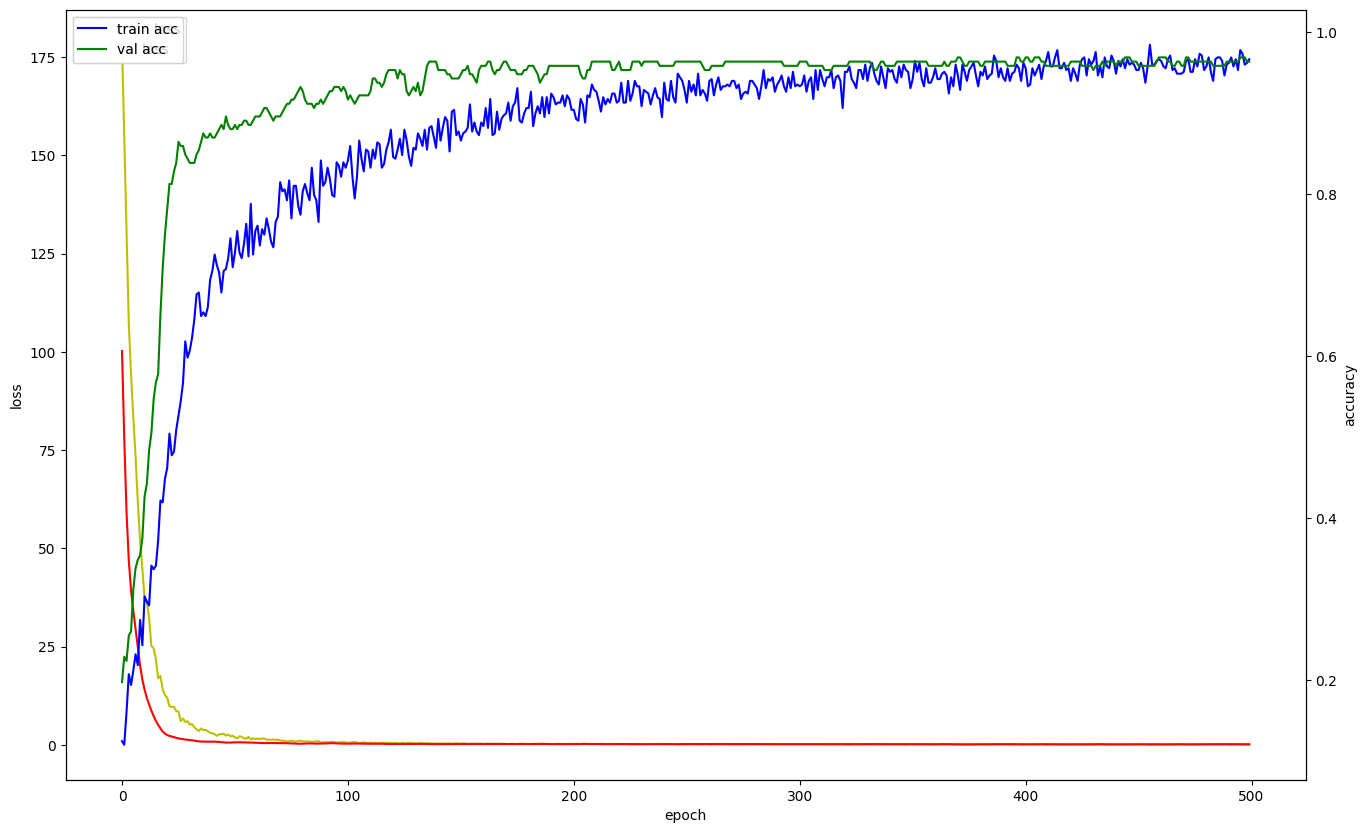

In [117]:
# 다중 분류
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

acc_ax.plot(acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

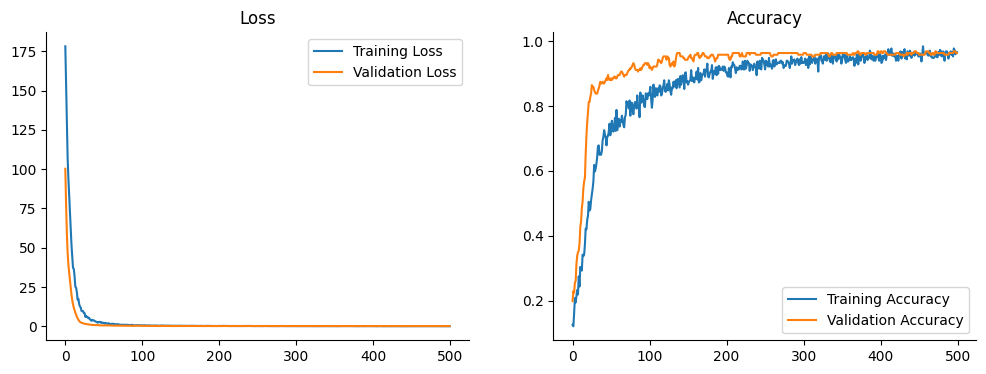

In [118]:
# MLP 모델
# 이진 분류
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["loss"], ax = axes[0],
             label = 'Training Loss')

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["val_loss"], ax = axes[0],
             label = 'Validation Loss')


sns.lineplot(x = range(len(history.history["categorical_accuracy"])),
             y = history.history["categorical_accuracy"], ax = axes[1],
             label = 'Training Accuracy')

sns.lineplot(x = range(len(history.history["categorical_accuracy"])),
             y = history.history["val_categorical_accuracy"], ax = axes[1],
             label = 'Validation Accuracy')
axes[0].set_title("Loss"); axes[1].set_title("Accuracy")

sns.despine()
plt.show()

In [119]:
# 모델 저장
model.save('../models/model_100_231211_2_epoch500.h5')

/home/ckdal/venv/mp_venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 03-2. RNN - 성능 검증

In [32]:
X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
539,9.924472,5.437760,16.093966,34.917622,151.029160,23.662046,16.038351,129.254013,42.001671,30.698189,120.998001,45.441139,47.977879,110.705086,50.572929
308,16.359552,2.998557,12.931503,119.032211,45.824856,113.178497,131.724228,63.422493,114.784874,134.195648,88.537025,87.874741,126.493759,30.961140,149.614975
491,28.981226,11.005153,10.501713,81.253159,81.924286,77.597328,90.256813,98.426567,71.599548,93.740395,104.135040,68.671860,95.473099,114.793884,63.180790
17,24.956261,7.135846,16.957922,7.740575,3.122910,4.644784,3.623511,3.526766,2.837470,6.240818,2.599354,3.236579,4.473602,6.060120,2.901892
398,12.332101,7.578300,18.158735,119.052231,38.103939,102.778076,132.649734,56.182476,108.353302,128.010391,59.890751,110.785576,117.685890,31.542004,132.033340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,30.093987,59.041405,30.627752,10.745037,1.583387,4.301016,7.553125,1.945184,7.336160,27.930441,137.999695,14.299557,43.494587,122.158958,11.817131
785,27.608139,23.696928,27.915325,38.170364,123.204643,36.351780,29.730982,5.521902,1.188966,30.792360,154.541473,14.303607,45.125725,133.548126,24.054884
366,14.709100,17.596455,19.980736,43.646629,114.848457,61.407406,45.880585,122.197044,56.627579,56.748974,119.358849,51.230583,62.894932,112.625580,56.640041
446,37.125217,8.850159,19.058865,119.954292,62.158768,94.701416,134.632767,73.803780,90.499092,142.788696,74.412376,92.303520,145.909821,53.419239,109.832878


In [33]:
y_test_encoded

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
df_angle_test = pd.DataFrame(X_test.iloc[13,:])
df_angle_test = df_angle_test.transpose()
df_angle_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
35,25.297415,24.738119,13.825315,141.55397,25.708836,123.127533,145.452499,37.806629,141.609589,140.173065,51.290585,119.159897,129.32782,40.220798,124.801559


In [56]:
model_test = keras.models.load_model("/home/ckdal/dev_ws/project/Dl_Project/models/model_epoch500.h5")
# angle_test = np.array([[2.356400489807128906e+01,6.761012554168701172e+00,6.285949230194091797e+00,8.304659843444824219e+00,6.339200019836425781e+00,4.894902706146240234e+00,4.375961303710937500e+00,6.588742256164550781e+00,4.068197727203369141e+00,7.041219234466552734e+00,5.034504413604736328e+00,4.858801364898681641e+00,1.002417564392089844e+01,7.321394920349121094e+00,4.523040771484375000e+00]])
# angle_test = df_
print(encoder.inverse_transform(model_test.predict(df_angle_test))[0, 0])

1/1 [==============================] - 0s 73ms/step
3.0


In [ ]:
# 카메라 인덱스 확인
# sudo apt-get install v4l-utils -y
# v4l2-ctl --list-devices

In [121]:
# 인식 결과를 단순히 출력하도록
max_num_hands = 1
actions = ['go', 'back', 'stop', 'left_spin', 'right_spin', 'speed_up', 'speed_down', 'bad_gesture']
gestures = {
    0:'go', 1:'back', 2:'stop', 3:'left_spin', 4:'right_spin', 5:'speed_up',
    6:'speed_down', 7:'bad_gesture'}

# encoder = OneHotEncoder(sparse_output = False)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands=max_num_hands,                            
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

model = keras.models.load_model("/home/ckdal/dev_ws/project/Dl_Project/models/model_100_231211_2_epoch500.h5")

cap = cv2.VideoCapture(0)
seq = []
action_seq = [] 

while cap.isOpened():

    ret, img = cap.read()

    if not ret:
        print("카메라 연결 실패")
        # break
        continue

    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result = hands.process(img)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if result.multi_hand_landmarks is not None:

        for res in result.multi_hand_landmarks:

            joint = np.zeros((21, 3))

            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z]

            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:]
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:]
            v = v2 - v1 # [20,3]

            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            angles = []

            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]
            
            angle = np.degrees(angle)

            data = np.array([angle], dtype=np.float32)
            
            idx = encoder.inverse_transform(model.predict([data]))[0,0]

            if idx in gestures.keys():
                cv2.putText(img, text=gestures[idx].upper(), org=(int(res.landmark[0].x * img.shape[1]), int(res.landmark[0].y * img.shape[0] + 20)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

            mp_drawing.draw_landmarks(img,
                                      res,
                                      mp_hands.HAND_CONNECTIONS
                                    #   mp_hands.get_default_hand_landmarks_style(),
                                    #   mp_hands.get_default_hand_connections_style()
            )
    
    cv2.imshow('Test', img)

    key = cv2.waitKey(5) & 0xFF

    if key == 27:
        cv2.destroyAllWindows()
        cap.release()
        break

I0000 00:00:1702287010.722097    7169 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702287010.723405  147369 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)


1/1 [==============================] - 0s 18ms/step
